In [123]:
# 1. Importar librerías necesarias

import os
os.environ["OMP_NUM_THREADS"] = "4"  # Limita los hilos para evitar memory leak en Windows

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import numpy as np





# Para mostrar gráficos en Jupyter Notebook
%matplotlib inline

# 2. Cargar el dataset (asegúrate de tener la ruta correcta)
dataset = pd.read_csv('archivo_gym_members_exercise_tracking_version2.csv')

### Paso 3. Seleccion de las variables fisicas que se usaran para clustering. Normalización explícita de las variables

In [124]:
# 3. Seleccionar las variables físicas que usaremos para clustering
features = ['Age', 'Weight (kg)', 'Height (m)', 'BMI', 'Fat_Percentage', 'Experience_Level', 'Workout_Frequency (days/week)']
X = dataset[features]

# Aplicamos StandardScaler a las variables, para que todas estén en la misma escala.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Paso 4 - Métricas de K-means para elegir K optimo


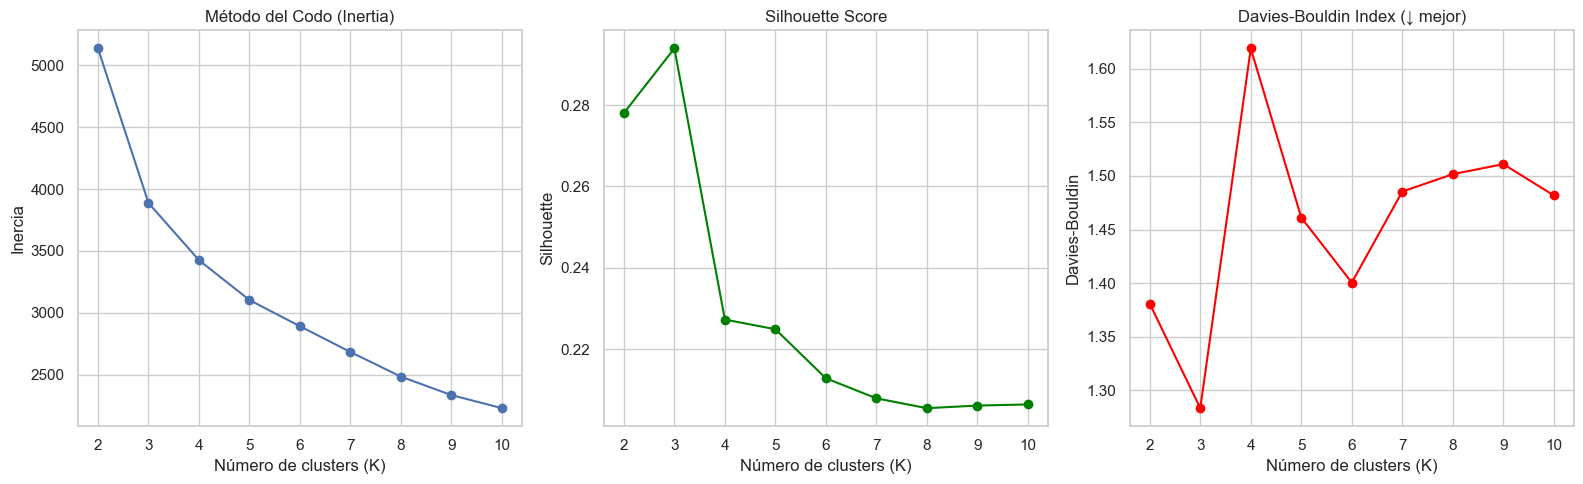

In [140]:
# 5. Evaluar métricas para distintos valores de K
K_range = range(2, 11)
inertias = []
silhouettes = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

# 6. Visualizar resultados
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.plot(K_range, inertias, marker='o')
plt.title("Método del Codo (Inertia)")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inercia")

plt.subplot(1, 3, 2)
plt.plot(K_range, silhouettes, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Silhouette")

plt.subplot(1, 3, 3)
plt.plot(K_range, davies, marker='o', color='red')
plt.title("Davies-Bouldin Index (↓ mejor)")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Davies-Bouldin")

plt.tight_layout()
plt.show()

### Paso 5. Aplicamos K-Means con el valor de K=4 obtenido de las graficas

In [126]:
# Aplicamos KMeans con K=4
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

# Asignar etiquetas de cluster al dataset
dataset['cluster'] = kmeans.labels_

##### _Pasos 4 y 5 – Elección del número óptimo de clusters (K=3)_

Para determinar el número óptimo de clusters, se evaluaron varios criterios métricos de validación interna del modelo de KMeans:

1. __Método del Codo (Inercia):__  
Se observa un punto de inflexión visible alrededor de **K=3–4**, donde la disminución de la inercia comienza a desacelerarse. Sin embargo, la ganancia marginal a partir de K=3 es baja, lo que sugiere que aumentar el número de clusters no mejora significativamente la compacidad. K=3 aparece como una elección más parsimoniosa.

2. __Silhouette Score:__  
El valor más alto del coeficiente de Silhouette se alcanza en **K=3**, lo cual indica una separación óptima entre grupos. A partir de ese valor, la métrica comienza a descender, señalando una mayor superposición y menor cohesión interna con más clusters.

3. __Davies-Bouldin Index:__  
El valor mínimo también se encuentra en **K=3**, reforzando la idea de que este número de clusters proporciona grupos bien definidos y separados. A partir de K=4, el índice aumenta, lo que indica una segmentación menos eficiente.

Dado que **K=3** maximiza la cohesión (Silhouette), la separación (Davies-Bouldin) y mantiene la simplicidad del modelo (Codo), se selecciona este valor como óptimo para aplicar KMeans. Esta elección permite obtener una segmentación equilibrada, coherente y representativa de la estructura natural del conjunto de datos.


### Paso 6. Los centroides representan el perfil promedio de cada cluster. Son vectores con la media de cada variable física para los puntos de ese cluster.

In [127]:
# 6. Obtener los centroides (puntos medios) de cada cluster
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=features)
print("\n #6. Centroides de los clusters:")
centroids


 #6. Centroides de los clusters:


,Age,Weight (kg),Height (m),BMI,Fat_Percentage,Experience_Level,Workout_Frequency (days/week)
0,39.419178,80.322740,1.746904,26.610137,23.277260,1.958904,3.493151
1,38.729614,56.698283,1.680665,20.330815,26.328755,1.791845,3.304721
2,36.640845,113.530986,1.797606,35.581972,24.908451,1.485915,2.936620


In [128]:
for i, row in centroids.iterrows():
 print(f"\nPerfil del Cluster {i}:")
 print(f"\nEdad promedio: {row['Age']:.1f} años")
 print(f"Peso promedio: {row['Weight (kg)']:.1f} kg")
 print(f"Altura promedio: {row['Height (m)']:.2f} m")
 print(f"IMC promedio: {row['BMI']:.1f}")
 print(f"Porcentaje de grasa corporal promedio: {row['Fat_Percentage']:.1f}%")
 print(f"Nivel de experiencia promedio: {row['Experience_Level']:.1f}")
 print(f"Frecuencia de entrenamiento promedio: {row['Workout_Frequency (days/week)']:.1f} días por semana")
 print("----------------------------------------------------------------------------------")


Perfil del Cluster 0:

Edad promedio: 39.4 años
Peso promedio: 80.3 kg
Altura promedio: 1.75 m
IMC promedio: 26.6
Porcentaje de grasa corporal promedio: 23.3%
Nivel de experiencia promedio: 2.0
Frecuencia de entrenamiento promedio: 3.5 días por semana
----------------------------------------------------------------------------------

Perfil del Cluster 1:

Edad promedio: 38.7 años
Peso promedio: 56.7 kg
Altura promedio: 1.68 m
IMC promedio: 20.3
Porcentaje de grasa corporal promedio: 26.3%
Nivel de experiencia promedio: 1.8
Frecuencia de entrenamiento promedio: 3.3 días por semana
----------------------------------------------------------------------------------

Perfil del Cluster 2:

Edad promedio: 36.6 años
Peso promedio: 113.5 kg
Altura promedio: 1.80 m
IMC promedio: 35.6
Porcentaje de grasa corporal promedio: 24.9%
Nivel de experiencia promedio: 1.5
Frecuencia de entrenamiento promedio: 2.9 días por semana
--------------------------------------------------------------------------

### Paso 7. Saber cuántas sesiones hay en cada cluster nos da una idea del tamaño relativo de cada grupo.


 #7. Cantidad de sesiones por cluster:
cluster
1    466
0    365
2    142
Name: count, dtype: int64


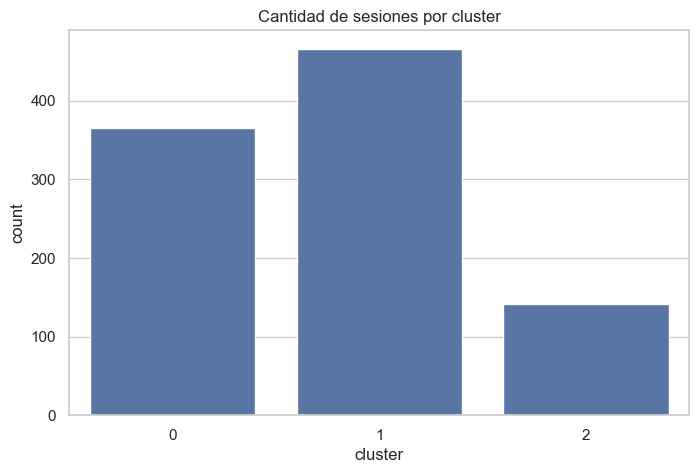

In [129]:
# 7. Ver cuántas sesiones hay en cada cluster
print("\n #7. Cantidad de sesiones por cluster:")
print(dataset['cluster'].value_counts())

# Gráfico de barras para cantidad de sesiones por cluster
plt.figure(figsize=(8, 5))
sns.countplot(x='cluster', data=dataset)
plt.title('Cantidad de sesiones por cluster')
plt.show()

### Paso 8. Visualización mediante Reducción de Dimensionalidad para ver cómo se agrupan visualmente los clusters

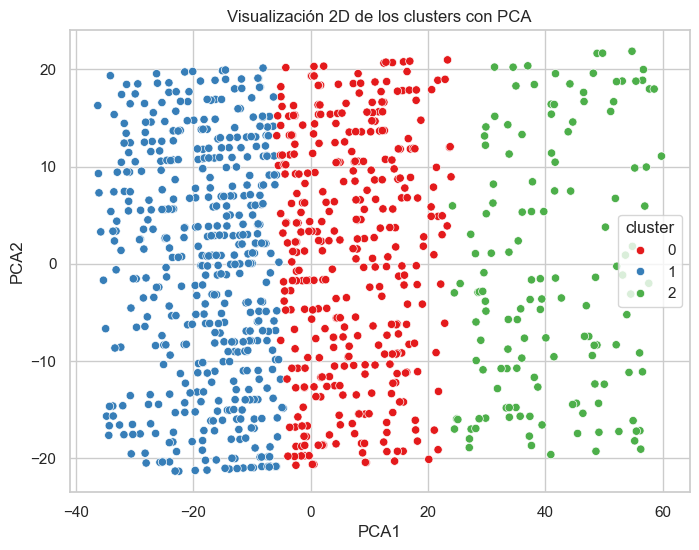

In [130]:
# Visualización tipo PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X)

df_plot = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])
df_plot['cluster'] = dataset['cluster']

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=df_plot, palette='Set1')
plt.title('Visualización 2D de los clusters con PCA')
plt.show()

### Paso 9. Frecuencia de cada tipo de ejercicio por cluster


In [131]:
# Ver frecuencia de cada tipo de ejercicio por cluster
for tipo in ['Workout_HIIT', 'Workout_Strength', 'Workout_Yoga', 'Workout_Cardio']:
    print(f'\nFrecuencia media de {tipo} por cluster:')
    print(dataset.groupby('cluster')[tipo].mean())


Frecuencia media de Workout_HIIT por cluster:
cluster
0    0.232877
1    0.221030
2    0.232394
Name: Workout_HIIT, dtype: float64

Frecuencia media de Workout_Strength por cluster:
cluster
0    0.263014
1    0.281116
2    0.218310
Name: Workout_Strength, dtype: float64

Frecuencia media de Workout_Yoga por cluster:
cluster
0    0.254795
1    0.240343
2    0.239437
Name: Workout_Yoga, dtype: float64

Frecuencia media de Workout_Cardio por cluster:
cluster
0    0.249315
1    0.257511
2    0.309859
Name: Workout_Cardio, dtype: float64


## Paso 10 – Interpretación de Clusters (K=3)

### 🔵 Cluster 0 – Usuarios intermedios y constantes

- **Edad promedio**: 39.4 años  
- **Peso / Altura / IMC**: 80.3 kg, 1.75 m, IMC de 26.6  
- **Grasa corporal**: 23.3%  
- **Nivel de experiencia**: 2.0  
- **Frecuencia de entrenamiento**: 3.5 días/semana  
- **Tipo de ejercicio más frecuente**: fuerza, HIIT y yoga en proporciones equilibradas.

**Interpretación**:  
Usuarios maduros con hábitos consistentes y experiencia considerable. A pesar de un IMC ligeramente elevado, tienen buen control del porcentaje graso. Este grupo representa personas activas, posiblemente con buena masa muscular. Pueden beneficiarse de programas para mejorar composición corporal o mantener su estado físico actual.

---

### 🟠 Cluster 1 – Usuarios jóvenes y delgados

- **Edad promedio**: 38.7 años  
- **Peso / Altura / IMC**: 56.7 kg, 1.68 m, IMC de 20.3  
- **Grasa corporal**: 26.3%  
- **Nivel de experiencia**: 1.8  
- **Frecuencia de entrenamiento**: 3.3 días/semana  
- **Tipo de ejercicio más frecuente**: fuerza

**Interpretación**:  
Aunque presentan un IMC bajo (delgadez), el porcentaje de grasa corporal es relativamente alto, lo cual sugiere poca masa muscular (sarcopenia). Este grupo tiene margen de mejora en cuanto a composición corporal. Ideal para planes orientados al aumento de fuerza y masa muscular. Su frecuencia de entrenamiento es adecuada, pero puede optimizarse la intensidad.

---

### 🔴 Cluster 2 – Usuarios con obesidad y baja frecuencia

- **Edad promedio**: 36.6 años  
- **Peso / Altura / IMC**: 113.5 kg, 1.80 m, IMC de 35.6  
- **Grasa corporal**: 24.9%  
- **Nivel de experiencia**: 1.5  
- **Frecuencia de entrenamiento**: 2.9 días/semana  
- **Tipo de ejercicio más frecuente**: cardio

**Interpretación**:  
Grupo con obesidad evidente y baja experiencia. A pesar de su alto peso corporal, el porcentaje graso no es desproporcionado, lo cual sugiere presencia de masa muscular. Sin embargo, su estilo de vida requiere mejoras sustanciales. Son candidatos ideales para intervenciones de pérdida de peso progresiva y programas adaptados a bajo impacto.

---

### 🔥 Implicaciones en la predicción de calorías quemadas

De acuerdo con el perfil físico y hábitos de entrenamiento, se espera el siguiente orden de gasto calórico (de menor a mayor):

1. 🟠 Cluster 1 – Bajo peso, poca masa muscular  
2. 🔵 Cluster 0 – Actividad media-alta, buena condición  
3. 🔴 Cluster 2 – Alta masa corporal, aunque baja frecuencia



### Centroides Escalados

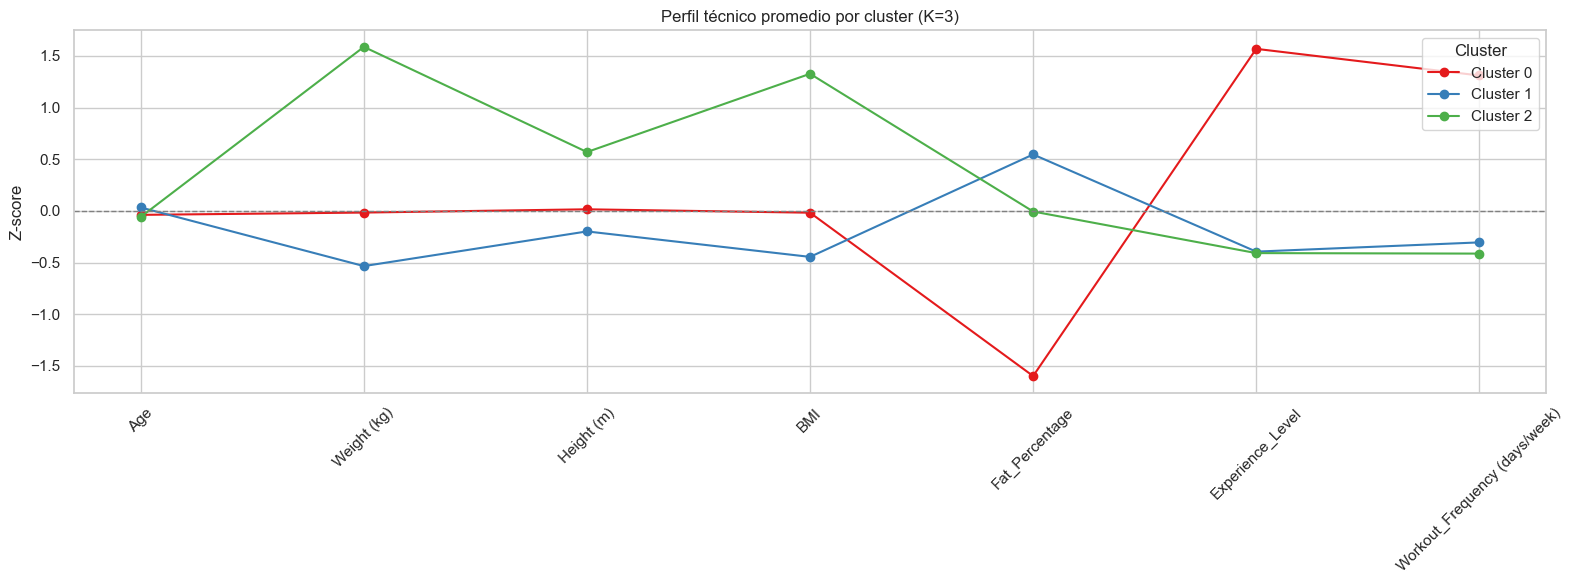


Centroides Z-score por cluster:
cluster                           0     1     2
Age                           -0.04  0.03 -0.06
Weight (kg)                   -0.02 -0.53  1.59
Height (m)                     0.02 -0.20  0.57
BMI                           -0.02 -0.45  1.33
Fat_Percentage                -1.60  0.55 -0.01
Experience_Level               1.57 -0.39 -0.41
Workout_Frequency (days/week)  1.31 -0.31 -0.41


In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Añadir cluster a los datos escalados
df_scaled = pd.DataFrame(X_scaled, columns=features)
df_scaled['cluster'] = dataset['cluster']

# Calcular la media estandarizada (Z-score) de cada atributo por cluster
centroids_z = df_scaled.groupby('cluster').mean().T

# Representación gráfica estilo perfil técnico (líneas con marcadores)
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")
palette = sns.color_palette("Set1", n_colors=centroids_z.shape[1])

for i, col in enumerate(centroids_z.columns):
    plt.plot(centroids_z.index, centroids_z[col], marker='o', label=f'Cluster {col}', color=palette[i])

plt.title("Perfil técnico promedio por cluster (K=3)")
plt.ylabel("Z-score")
plt.xticks(rotation=45)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.legend(title="Cluster", loc="upper right")
plt.tight_layout()
plt.show()

centroids_table = df_scaled.groupby('cluster').mean().T.round(2)
print("\nCentroides Z-score por cluster:")
print(centroids_table)

#### Generamos un nuevo dataset para añadir al que ya teniamos una nueva columna Cluster. Cada sesion de entrenamiento tendrá asignado el Cluster al que representa

In [134]:
dataset['cluster'] = kmeans.fit_predict(X_scaled)
dataset.to_csv("dataset_con_clusters.csv", index=False)

In [135]:
import joblib

# Guardar el scaler y el modelo KMeans
joblib.dump(scaler, "scaler.pkl")
joblib.dump(kmeans, "kmeans.pkl")

['kmeans.pkl']

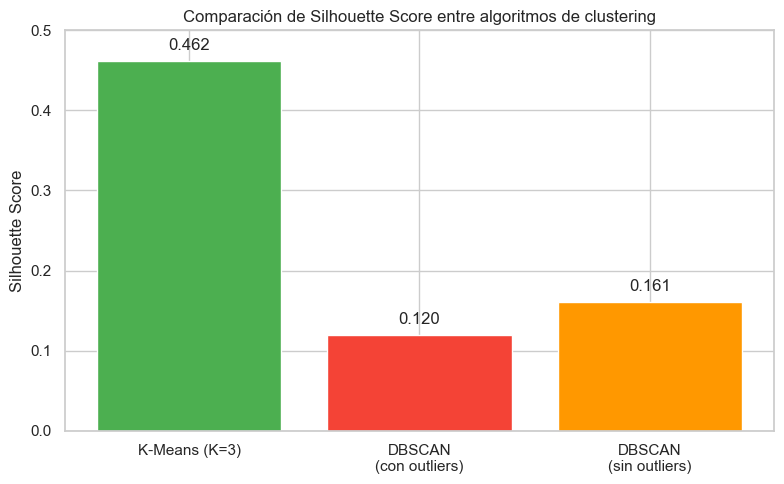

In [141]:
import matplotlib.pyplot as plt

# Datos
algorithms = ['K-Means (K=3)', 'DBSCAN\n(con outliers)', 'DBSCAN\n(sin outliers)']
silhouette_scores = [0.462, 0.120, 0.161]

# Gráfica
plt.figure(figsize=(8, 5))
bars = plt.bar(algorithms, silhouette_scores, color=['#4CAF50', '#F44336', '#FF9800'])
plt.ylim(0, 0.5)
plt.title('Comparación de Silhouette Score entre algoritmos de clustering')
plt.ylabel('Silhouette Score')

# Añadir etiquetas a las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.3f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()
